# Contact-High-School

In [1]:
import pandas as pd
import json

In [2]:
with open('../../data/raw/contact-high-school/hyperedges-contact-high-school.txt', 'r') as f:
    hyperedges = [list(map(int, line.strip().split(','))) for line in f]

with open('../../data/raw/contact-high-school/label-names-contact-high-school.txt', 'r') as f:
    node_lables = [line.strip() for line in f] 
    # ['2BIO1', '2BIO2', '2BIO3', 'MP*1', 'MP*2', 'PSI*', 'PC', 'PC*', 'MP']

with open('../../data/raw/contact-high-school/node-labels-contact-high-school.txt', 'r') as f:
    nodLabelIdx = [int(line.strip()) for line in f]
    # unique elements: array([1, 2, 3, 4, 5, 6, 7, 8, 9])

nodLabels = [node_lables[idx-1] for idx in nodLabelIdx]

In [3]:
# load hlrc and hfrc
contact_high = pd.read_pickle('derived_data/hlrc_hfrc.pkl')

# load horc
with open('derived_data/horc.json', "r") as f:
        data = json.load(f)
        contact_high['horc'] = data['aggregations'][0]['edge_curvature']

In [4]:
contact_high.head()

,edges,nodLabels,hlrc,hfrc,horc
0,"[205, 258, 292]","[PC, PC, PC]",0.343770,-273,0.541457
1,"[3, 7, 42, 47]","[2BIO3, 2BIO3, 2BIO3, 2BIO3]",-0.101521,-218,0.498670
2,"[65, 117]","[2BIO3, 2BIO3]",0.271318,-127,0.577515
3,"[292, 303]","[PC, PC]",0.296339,-145,0.459733
4,"[9, 269]","[PC, PC]",0.204074,-185,0.327432


## Graph visualization

In [11]:
import xgi
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.cm as cm

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'savefig.bbox': 'tight',
    'savefig.transparent':True})

In [6]:
H = xgi.Hypergraph(contact_high['edges'].to_list())

In [7]:
node_pos = xgi.pairwise_spring_layout(H, seed=123, iterations=100)

In [8]:
# node colors
label_color = {'2BIO1': '#752104', '2BIO2': '#BB5A3F', '2BIO3': '#EA7E73',
               'MP': '#1B1464','MP*1': '#2E5AB4', 'MP*2': '#00A0C8',
               'PC': '#006837', 'PC*': '#39B54A',
               'PSI*': '#F7931E'}
node_colors= {i: label_color[nodLabels[i-1]] for i in list(H.nodes)}

# edge color
normalized_hlrc = {key: (value+1) / 2 for key, value in enumerate(contact_high['hlrc'])}
cmap = matplotlib.colormaps.get_cmap('RdYlBu_r')
edge_color = {key: cmap(normalized_hlrc[key]) for key in normalized_hlrc}

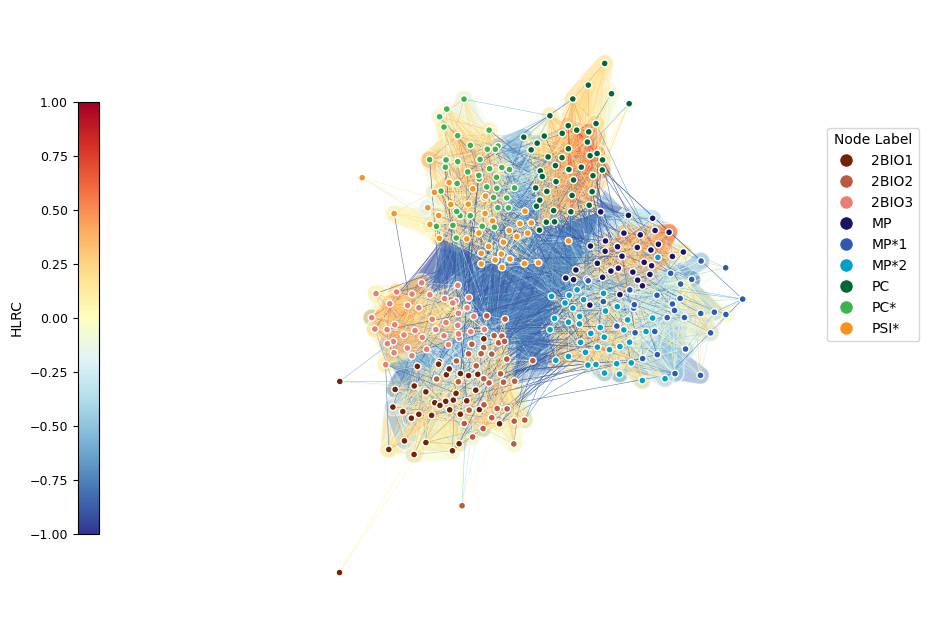

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
xgi.draw(
    H, 
    pos=node_pos,
    node_size=5,
    node_ec = 'white', # color of node border
    node_fc = node_colors, # node color
    edge_fc= edge_color, # edge color
    edge_ec= "white",
    dyad_color=edge_color, # edge with size 2 color
    dyad_style="-",
    dyad_lw=0.35,
    alpha=0.4,
    hull = True,
    radius = 0.03,
    rescale_sizes=False);

# Add colorbar
norm = mcolors.Normalize(vmin=-1, vmax=1)  # Set the normalization to match the original value range
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, shrink=0.7,location='left')
cbar.set_label('HLRC') 

handles_grouped = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, 
                               markerfacecolor=mcolors.to_rgba(label_color[label])) 
                   for label in ['2BIO1', '2BIO2', '2BIO3', 'MP', 'MP*1', 'MP*2', 'PC', 'PC*', 'PSI*']]
plt.legend(handles_grouped, ['2BIO1', '2BIO2', '2BIO3', 'MP', 'MP*1', 'MP*2', 'PC', 'PC*', 'PSI*'], title="Node Label",
           bbox_to_anchor=(0.9, 0.82), loc='upper left', borderaxespad=0.5)
plt.savefig("./figures/contact_high.pdf",bbox_inches='tight');

## Curvature Comparison

In [6]:
contact_high["nLabels"] = [len(set(labels)) for labels in contact_high["nodLabels"]]
contact_high["edgeLabels"] = ["between" if nLabels > 1 else "within" for nLabels in contact_high["nLabels"]]
contact_high.head()

,edges,nodLabels,hlrc,hfrc,horc,nLabels,edgeLabels
0,"[205, 258, 292]","[PC, PC, PC]",0.343770,-273,0.541457,1,within
1,"[3, 7, 42, 47]","[2BIO3, 2BIO3, 2BIO3, 2BIO3]",-0.101521,-218,0.498670,1,within
2,"[65, 117]","[2BIO3, 2BIO3]",0.271318,-127,0.577515,1,within
3,"[292, 303]","[PC, PC]",0.296339,-145,0.459733,1,within
4,"[9, 269]","[PC, PC]",0.204074,-185,0.327432,1,within


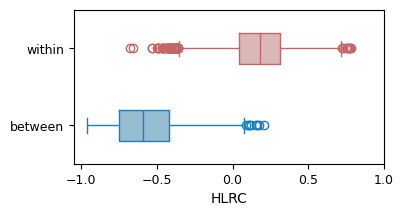

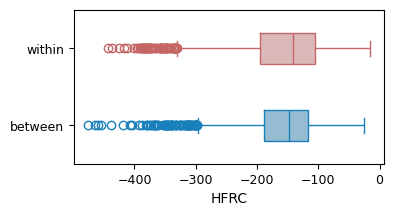

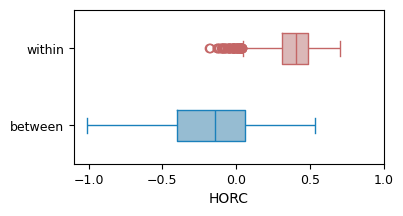

In [11]:
plt.subplots(figsize=(4, 2))
spec = dict(data = contact_high, x = "hlrc", y = "edgeLabels", hue="edgeLabels", width = .4)
sns.boxplot(**spec, linewidth=0, showfliers=False, boxprops=dict(alpha=.5), palette={"within": "#c46666","between": "#1a80bb"})
sns.boxplot(**spec, linewidth=1, fill=False, legend=False, palette={"within": "#c46666","between": "#1a80bb"} )
plt.xticks([-1.0,-0.5, 0.0, 0.5, 1.0]);
plt.ylabel("")
plt.xlabel("HLRC")
plt.savefig("./figures/contact_high_HLRC.pdf",bbox_inches='tight');

plt.subplots(figsize=(4, 2))
spec = dict(data = contact_high, x = "hfrc", y = "edgeLabels", hue="edgeLabels", width = .4)
sns.boxplot(**spec, linewidth=0, showfliers=False, boxprops=dict(alpha=.5), palette={"within": "#c46666","between": "#1a80bb"})
sns.boxplot(**spec, linewidth=1, fill=False, legend=False, palette={"within": "#c46666","between": "#1a80bb"} )
plt.ylabel("")
plt.xlabel("HFRC")
plt.savefig("./figures/contact_high_HFRC.pdf",bbox_inches='tight');

plt.subplots(figsize=(4, 2))
spec = dict(data = contact_high, x = "horc", y = "edgeLabels", hue="edgeLabels", width = .4)
sns.boxplot(**spec, linewidth=0, showfliers=False, boxprops=dict(alpha=.5), palette={"within": "#c46666","between": "#1a80bb"})
sns.boxplot(**spec, linewidth=1, fill=False, legend=False, palette={"within": "#c46666","between": "#1a80bb"} )
plt.xticks([-1.0,-0.5, 0.0, 0.5, 1.0]);
plt.ylabel("")
plt.xlabel("HORC")
plt.savefig("./figures/contact_high_HORC.pdf",bbox_inches='tight');

In [13]:
# test
from scipy.stats import mannwhitneyu # wilcox-rank sum test
for curvature in ['hlrc','hfrc','horc']:
    
    group1 = contact_high.loc[contact_high['edgeLabels'] == 'within', curvature]
    group2 = contact_high.loc[contact_high['edgeLabels'] == 'between', curvature]

    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(group1, group2, alternative='greater')
    print("Curvature:", curvature)
    print("- Statistic:", stat)
    print("- p-value:", p_value)

Curvature: hlrc
- Statistic: 11870361.5
- p-value: 0.0
Curvature: hfrc
- Statistic: 6332171.0
- p-value: 8.725481774745114e-05
Curvature: horc
- Statistic: 11499351.0
- p-value: 0.0
